In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [27]:
import os
import math
import numpy as np
import pandas as pd
import time
import string
import random
import sys
from logger import Logger
from abc import ABC
from datetime import timedelta
from sklearn import metrics
from sklearn.utils import resample
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
#from selection_strategy    import RandomSelectionStrategy
sys.path.insert(0,os.pardir)
from ga_inverse import readData
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import ConstantKernel
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import RationalQuadratic
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import warnings
import matplotlib.animation as animation
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_predict
from catboost import CatBoostRegressor
from scipy.spatial.distance import cdist
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import itertools
from scipy import stats


In [3]:
from abc import ABC

class SelectionStrategy(ABC):
    def select_next_instance():
        pass

class RandomSelectionStrategy(SelectionStrategy):
    def __init__(self):
        pass
        #self.logPrefix = "Random Selection Strategy"

    def select_next_instance(self, candidate_instances: pd.DataFrame):
        selected = np.random.choice(candidate_instances, size=1, replace=False)[0]
        #self.logger.info(self.logPrefix, "Randomly Selected Zif: " + selected)
        return selected   

In [4]:
def plot_data_exists(data_path) -> bool:

    """ Check wheather plot data already exist and return the respective truth value.
        data_path1:     The path to look for the set of data."""

    if not os.path.exists(data_path):
        return False

    return True

def data_preparation(sourceFile=None, research_data="zifs_diffusivity") -> list:

    Y = []
    X = []

    if research_data == "zifs_diffusivity":
        if sourceFile is not None:
            data_from_file = readData(sourceFile)
        else:
            data_from_file = readData()

        Y = ["logD"]
        X = ['diameter','mass','ascentricF', 'kdiameter','ionicRad',
            'MetalNum','MetalMass','σ_1', 'e_1',
            'linker_length1', 'linker_length2', 'linker_length3',
            'linker_mass1', 'linker_mass2', 'linker_mass3',
            'func1_length', 'func2_length', 'func3_length', 
            'func1_mass', 'func2_mass', 'func3_mass']
    
    elif research_data == "co2":
        data_from_file = pd.read_csv(sourceFile)
        data_from_file = data_from_file.rename(columns={'CO2_working_capacity(mol/kg)':'working_capacity', 'mof_name':'type'})

        # One Hot Encode Data
        features = ["Nodular_BB1", "Nodular_BB2", "Connecting_BB1", "Connecting_BB2"]
        data_from_file = pd.get_dummies(data_from_file, columns=features,dtype=int)

        Y = ["working_capacity"]
        X = [feature_label for base_label in features for feature_label in list(data_from_file.columns) if base_label in feature_label]

    elif research_data == "co2/n2":
        data_from_file = pd.read_csv(sourceFile)
        data_from_file = data_from_file.rename(columns={'CO2/N2_selectivity':'selectivity', 'mof_name':'type'})

        # One Hot Encode Data
        features = ["Nodular_BB1", "Nodular_BB2", "Connecting_BB1", "Connecting_BB2"]
        data_from_file = pd.get_dummies(data_from_file, columns=features,dtype=int)

        Y = ["selectivity"]
        X = [feature_label for base_label in features for feature_label in list(data_from_file.columns) if base_label in feature_label]    

    elif research_data == "o2":
        data_from_file = pd.read_csv(sourceFile)

        
        data_from_file["SelfdiffusionofO2cm2s"] = np.log(data_from_file["SelfdiffusionofO2cm2s"])
        data_from_file = data_from_file.rename(columns={'SelfdiffusionofO2cm2s':'logSelfD','MOFRefcodes': 'type'})
        Y = ["logSelfD"]
        
        X = ['LCD',	'PLD',	'LFPD',	'Volume',	'ASA_m2_g',	
             'ASA_m2_cm3',	'NASA_m2_g', 'NASA_m2_cm3',	
             'AV_VF',	'AV_cm3_g',	'NAV_cm3_g', ' H', 'C',	'N', 'metal type', 
             ' total degree of unsaturation', 'metalic percentage',	' oxygetn-to-metal ratio',	
             'electronegtive-to-total ratio', ' weighted electronegativity per atom', 
             ' nitrogen to oxygen ']  #, 'mass',	'ascentricF',	'diameter',	'kdiameter'

    elif research_data == "n2":
        data_from_file = pd.read_csv(sourceFile)

        
        data_from_file["SelfdiffusionofN2cm2s"] = np.log(data_from_file["SelfdiffusionofN2cm2s"])
        data_from_file = data_from_file.rename(columns={'SelfdiffusionofN2cm2s':'logSelfD','MOFRefcodes': 'type'})
        Y = ["logSelfD"]
        
        X = ['LCD',	'PLD',	'LFPD',	'Volume',	'ASA_m2_g',	
             'ASA_m2_cm3',	'NASA_m2_g', 'NASA_m2_cm3',	
             'AV_VF',	'AV_cm3_g',	'NAV_cm3_g', ' H', 'C',	'N', 'metal type', 
             ' total degree of unsaturation', 'metalic percentage',	' oxygetn-to-metal ratio',	
             'electronegtive-to-total ratio', ' weighted electronegativity per atom', 
             ' nitrogen to oxygen ']  #, 'mass',	'ascentricF',	'diameter',	'kdiameter'         

    elif research_data == "ch4":
        data_from_file = pd.read_csv(sourceFile)

        
        data_from_file["D_CH4 (cm2/s)"] = np.log(data_from_file["D_CH4 (cm2/s)"])
        data_from_file = data_from_file.rename(columns={'D_CH4 (cm2/s)':'logSelfD','MOF name': 'type'})
        Y = ["logSelfD"]
        
        X = ['LCD (Å)','LCD/PLD','PLD (Å)','density (g/cm3)','Pore Volume (cm3/g)','Porosity','Surface Area (m2/g)',
        '%C','%H','%O','%N','%Halojen','%Metalloids','%Ametal','%Metal','O-to-M','MP','TDU','DU']  #, 'mass',	'ascentricF',	'diameter',	'kdiameter'

    elif research_data == "h2":
        data_from_file = pd.read_csv(sourceFile)

        
        data_from_file["D_H2 (cm2/s)"] = np.log(data_from_file["D_H2 (cm2/s)"])
        data_from_file = data_from_file.rename(columns={'D_H2 (cm2/s)':'logSelfD','MOF': 'type'})
        Y = ["logSelfD"]
        
        X = ['LCD (Å)','LCD/PLD','PLD (Å)','density (g/cm3)','Pore Volume (cm3/g)','Porosity','Surface Area (m2/g)',
        '%C','%H','%O','%N','%Halojen','%Metalloids','%Ametal','%Metal','O-to-M','MP','TDU','DU']

    elif research_data == "he":
        data_from_file = pd.read_csv(sourceFile)

        
        data_from_file["D_He (cm2/s)"] = np.log(data_from_file["D_He (cm2/s)"])
        data_from_file = data_from_file.rename(columns={'D_He (cm2/s)':'logSelfD','MOF': 'type'})
        Y = ["logSelfD"]
        
        X = ['LCD (Å)','LCD/PLD','PLD (Å)','density (g/cm3)','Pore Volume (cm3/g)','Porosity','Surface Area (m2/g)','%C','%H','%O','%N','%Halojen','%Metalloids','%Ametal','%Metal','TDU','DU','MP','O-to-M']    

    else:
        data_from_file = pd.read_csv(sourceFile)
        data_from_file = data_from_file.rename(columns={' absolute methane uptake high P [v STP/v]':'methane_uptake', ' name':'type'})        

        Y = ['methane_uptake']
        X = ['dimensions', ' supercell volume [A^3]', ' density [kg/m^3]',
             ' surface area [m^2/g]', ' num carbon', ' num hydrogen',
             ' num nitrogen', ' num oxygen', ' num sulfur', ' num silicon',
             ' vertices', ' edges', ' genus', ' largest included sphere diameter [A]',
             ' largest free sphere diameter [A]', ' largest included sphere along free sphere path diameter [A]']

    return data_from_file, X, Y

In [33]:
# Dataset Creation Forrester
np.random.seed(10)
# 1-d dataset Forrester Function 
#x = np.linspace(0, 1, 1000)

# Generate a large number of x values in the range [0.6, 0.9] and ensure uniqueness
x_60 = np.random.choice(np.linspace(0.6, 0.9, 10000), size=600, replace=False)

# Generate a large number of x values in the range [0, 0.6) and ensure uniqueness
x_20_1 = np.random.choice(np.linspace(0, 0.6, 10000), size=200, replace=False)

# Generate a large number of x values in the range [0.9, 1] and ensure uniqueness
x_20_2 = np.random.choice(np.linspace(0.9, 1, 10000), size=200, replace=False)

# Combine the x values
x = np.concatenate((x_60, x_20_1, x_20_2))

# Sort x values if you need them to be ordered
x = np.sort(x)
# Calculate the corresponding y values using the given formula
y = (6 * x - 2) ** 2 * np.sin(12 * x - 4)

# Create unique names for each sample
types = [f"Sample_{i+1}" for i in range(1000)]

# Create a DataFrame with columns x, y, and type
np_data = pd.DataFrame({'x': x, 'y': y, 'type': types})

featureNames = ['x']
targetNames = ['y']


In [5]:
# Dataset Creation Jump Forrester
np.random.seed(10)
x1 = np.linspace(0, 0.5, 500)
x2 = np.linspace(0.5, 1, 500)

###### Inbalanced
# x1 = np.random.choice(np.linspace(0, 0.5, 10000), size=300, replace=False)
# x2 = np.random.choice(np.linspace(0.5, 1, 10000), size=700, replace=False)


x = np.concatenate((x1,x2))


y1 = (6 * x1 - 2) ** 2 * np.sin(12 * x1 - 4)
y2 = (6 * x2 - 2) ** 2 * np.sin(12 * x2 - 4) + 10
y = np.concatenate((y1,y2))

# Create unique names for each sample
types = [f"Sample_{i+1}" for i in range(1000)]

# Create a DataFrame with columns x, y, and type
np_data = pd.DataFrame({'x': x, 'y': y, 'type': types})

featureNames = ['x']
targetNames = ['y']


In [40]:
# Dataset Creation ALOS D=2
x1 = np.linspace(0, 1, 100)
x2 = np.linspace(0, 1, 100)

# Create all possible unique pairs using itertools.product
all_pairs = np.array(list(itertools.product(x1, x2)))

# Randomly select 2000 unique pairs
selected_indices = np.random.choice(len(all_pairs), size=2000, replace=False)
selected_pairs = all_pairs[selected_indices]

# Define a function to calculate y
def calculate_y(x1, x2):
    return np.sin(21*(x1-0.9)**4) * np.cos(2*(x1-0.9)) + (x1-0.7)/2 + 2*(x2**2) * np.sin(x1)

# Calculate y for each pair
y = np.array([calculate_y(pair[0], pair[1]) for pair in selected_pairs])

types = [f"Sample_{i+1}" for i in range(2000)]

# Combine x1, x2, and y into a DataFrame
np_data = pd.DataFrame(selected_pairs, columns=['x1', 'x2'])
np_data['y'] = y
np_data['type'] = types

featureNames = ['x1','x2']
targetNames = ['y']

In [42]:
# Dataset Creation ALOS D=2

x1_1 = np.linspace(0, 0.2, 20)
x1_2 = np.linspace(0.2, 0.4, 20)
x1_3 = np.linspace(0.4, 1, 60)
x2 = np.linspace(0, 1, 100)

# Create all possible unique pairs using itertools.product
all_pairs1 = np.array(list(itertools.product(x1_1, x2)))
all_pairs2 = np.array(list(itertools.product(x1_2, x2)))
all_pairs3 = np.array(list(itertools.product(x1_3, x2)))


# Randomly select 2000 unique pairs
selected_indices1 = np.random.choice(len(all_pairs1), size=300, replace=False)
selected_pairs1 = all_pairs1[selected_indices1]

selected_indices2 = np.random.choice(len(all_pairs2), size=700, replace=False)
selected_pairs2 = all_pairs2[selected_indices2]

selected_indices3 = np.random.choice(len(all_pairs3), size=1000, replace=False)
selected_pairs3 = all_pairs3[selected_indices3]

selected_pairs = np.concatenate((selected_pairs1,selected_pairs2,selected_pairs3))

print(selected_pairs.shape)
# Define a function to calculate y
def calculate_y(x1, x2):
    return np.sin(21*(x1-0.9)**4) * np.cos(2*(x1-0.9)) + (x1-0.7)/2 + 2*(x2**2) * np.sin(x1)

# Calculate y for each pair
y = np.array([calculate_y(pair[0], pair[1]) for pair in selected_pairs])

types = [f"Sample_{i+1}" for i in range(2000)]

# Combine x1, x2, and y into a DataFrame
np_data = pd.DataFrame(selected_pairs, columns=['x1', 'x2'])
np_data['y'] = y
np_data['type'] = types

featureNames = ['x1','x2']
targetNames = ['y']


(2000, 2)


In [44]:
# Dataset Gaussian
np.random.seed(10)
# Generate linspace for x1 and x2
x1 = np.linspace(-3, 3, 100)
x2 = np.linspace(-3, 3, 100)

# Create all possible unique pairs using itertools.product
all_pairs = np.array(list(itertools.product(x1, x2)))

# Randomly select 2000 unique pairs
selected_indices = np.random.choice(len(all_pairs), size=2000, replace=False)
selected_pairs = all_pairs[selected_indices]

# Define the 2D Gaussian function
def gaussian_2d(x1, x2, sigma=1):
    return np.exp(-(x1**2 + x2**2) / (2 * sigma**2))

# Calculate y for each pair
y = np.array([gaussian_2d(pair[0], pair[1]) for pair in selected_pairs])

# Combine x1, x2, and y into a DataFrame
np_data = pd.DataFrame(selected_pairs, columns=['x1', 'x2'])
np_data['y'] = y

types = [f"Sample_{i+1}" for i in range(2000)]
np_data['type'] = types

featureNames = ['x1','x2']
targetNames = ['y']

In [67]:
# Inbalanced Gaussian
np.random.seed(10)

# Generate linspace for x1 and x2
x1_1 = np.linspace(-0.5, 0.5, 100)
x2_1 = np.linspace(-0.5, 0.5, 100)

# Create all possible unique pairs using itertools.product
all_pairs1 = np.array(list(itertools.product(x1_1, x2_1)))

# Randomly select 2000 unique pairs
selected_indices = np.random.choice(len(all_pairs1), size=500, replace=False)
selected_pairs1 = all_pairs1[selected_indices]

# Generate linspace for x1 and x2
x1_2 = np.linspace(-3, 3, 100)
x2_2 = np.linspace(-3, 3, 100)

all_pairs = np.array(list(itertools.product(x1_2, x2_2)))

outside_range_pairs = all_pairs[~((all_pairs[:, 0] >= -0.5) & (all_pairs[:, 0] <= 0.5) & 
                                  (all_pairs[:, 1] >= -0.5) & (all_pairs[:, 1] <= 0.5))]


selected_outside_indices = np.random.choice(len(outside_range_pairs), size=1500, replace=False)
selected_outside_pairs = outside_range_pairs[selected_outside_indices]


combined_pairs = np.vstack([selected_pairs1, selected_outside_pairs])

# Define the 2D Gaussian function
def gaussian_2d(x1, x2, sigma=1):
    return np.exp(-(x1**2 + x2**2) / (2 * sigma**2))

# Calculate y for each pair
y = np.array([gaussian_2d(pair[0], pair[1]) for pair in combined_pairs])

# Combine x1, x2, and y into a DataFrame
np_data = pd.DataFrame(combined_pairs, columns=['x1', 'x2'])
np_data['y'] = y

# Assign sample types
types = [f"Sample_{i+1}" for i in range(2000)]
np_data['type'] = types

featureNames = ['x1','x2']
targetNames = ['y']

In [5]:
# Define the 2D Gaussian function
def gaussian_2d(x1, x2,noise,sigma=1):
    return np.exp(-(x1**2 + x2**2) / (2 * sigma**2)) + np.random.uniform(0, noise)

# Inbalanced Gaussian + noise
np.random.seed(10)

# Generate linspace for x1 and x2
x1_1 = np.linspace(-0.5, 0.5, 100)
x2_1 = np.linspace(-0.5, 0.5, 100)

# Create all possible unique pairs using itertools.product
all_pairs1 = np.array(list(itertools.product(x1_1, x2_1)))

# Randomly select 2000 unique pairs
selected_indices = np.random.choice(len(all_pairs1), size=500, replace=False)
selected_pairs1 = all_pairs1[selected_indices]

y1 = np.array([gaussian_2d(pair[0], pair[1],0.5) for pair in selected_pairs1])

# Generate linspace for x1 and x2
x1_2 = np.linspace(-3, 3, 100)
x2_2 = np.linspace(-3, 3, 100)

all_pairs = np.array(list(itertools.product(x1_2, x2_2)))

outside_range_pairs = all_pairs[~((all_pairs[:, 0] >= -0.5) & (all_pairs[:, 0] <= 0.5) & 
                                  (all_pairs[:, 1] >= -0.5) & (all_pairs[:, 1] <= 0.5))]


selected_outside_indices = np.random.choice(len(outside_range_pairs), size=1500, replace=False)
selected_outside_pairs = outside_range_pairs[selected_outside_indices]

y2 = np.array([gaussian_2d(pair[0], pair[1],0.2) for pair in selected_outside_pairs])

combined_pairs = np.vstack([selected_pairs1, selected_outside_pairs])


# Calculate y for each pair
y = np.concatenate((y1,y2))

# Combine x1, x2, and y into a DataFrame
np_data = pd.DataFrame(combined_pairs, columns=['x1', 'x2'])
np_data['y'] = y

# Assign sample types
types = [f"Sample_{i+1}" for i in range(2000)]
np_data['type'] = types

featureNames = ['x1','x2']
targetNames = ['y']

In [22]:
#np_data, featureNames, targetNames = data_preparation("../train_data/train_zifs_diffusivity/TrainData.xlsx")
#np_data, featureNames, targetNames = data_preparation("../train_data/MOFsMMM/Methane.csv",research_data = "ch4")
#np_data, featureNames, targetNames = data_preparation("../train_data/properties.csv",research_data = "methane")
#np_data, featureNames, targetNames = data_preparation("../train_data/MOFdata.csv",research_data = "o2")
#np_data, featureNames, targetNames = data_preparation("../train_data/MOFsMMM/Hydrogen.csv",research_data = "h2")
#np_data, featureNames, targetNames = data_preparation("../train_data/MOFsMMM/Helium.csv",research_data = "he")
#np_data, featureNames, targetNames = data_preparation("../train_data/alpha_ads_data_and_CO2_WC_data.csv",research_data = "co2/n2")
# Instantiate the XGB regressor model
XGBR = XGBRegressor(n_estimators=500, max_depth=5, eta=0.07, subsample=0.75, colsample_bytree=0.7, reg_lambda=0.4, reg_alpha=0.13,
                        random_state=6410 ) #,device = "cuda"

#gp_model = GaussianProcessRegressor(kernel=RationalQuadratic(length_scale=1.0, alpha=1.5))

In [7]:
# Initial Query Selection Indexes
for i in range(10):

    #start_indexes = np.random.choice(np.arange(0,100),size=5,replace=False)
    print(np.load(f'./Init_Index/start_{i}.npy'))

[55 40  0 83 58]
[97 56 62 20 70]
[58 30  0 37 94]
[95 65 20 72 84]
[19 15 51 75 93]
[48 49 75 82 45]
[68 27 98 45 28]
[66 60 31 34 80]
[78 64 84 99 88]
[96 58  1 37 93]


In [6]:
### Bootstraping for estimating confidence 
def train_ensemble(X, y, n_models=10):
    models = []
    for i in range(n_models):
        # Bootstrap sampling
        X_sample, y_sample = resample(X, y)
        model = XGBRegressor(n_estimators=500, max_depth=5, eta=0.07, subsample=0.75, colsample_bytree=0.7, reg_lambda=0.4, reg_alpha=0.13,
                        random_state=(6410))
        model.fit(X_sample, y_sample.ravel())
        models.append(model)
    return models

def predict_with_ensemble(models, X):
    predictions = np.array([model.predict(X) for model in models])
    mean_prediction = np.mean(predictions, axis=0)
    std_prediction = np.std(predictions, axis=0)
    return mean_prediction, std_prediction

def uncertainty_sampling(models, X_unlabeled,fefeatureNames):
    x_unlabeled = X_unlabeled[featureNames].to_numpy()
    _, std_prediction = predict_with_ensemble(models, x_unlabeled)
    # Select the top k most uncertain samples
    #uncertain_indices = std_prediction.argsort()[-k:]
    return std_prediction #uncertain_indices

In [7]:
### GP uncertainty
def Gp_uncertainty(X_train,y_train,X_unlabeled,featureNames):
    x_unlabeled = X_unlabeled[featureNames].to_numpy()
    # Define GP surrogate
    gp_model = GaussianProcessRegressor(kernel=RationalQuadratic(length_scale=1.0, alpha=1.5))  #RationalQuadratic(length_scale=1.0, alpha=1.5)
    gp_model.fit(X_train,y_train.ravel())
    y_pred, y_std = gp_model.predict(x_unlabeled,return_std=True)

    #y_std_mean = np.mean(y_std)
    #y_std  = np.abs(y_std - y_std_mean)
    uncertainties = y_std #.argsort()[-1:]
    return uncertainties

In [8]:
def Greedy_AL(model,X_train,y_train,X_unlabeled,featureNames,targetNames):
   x_unlabeled = X_unlabeled[featureNames].to_numpy()  
   y_pred = model.predict(x_unlabeled)
   
   y_true = X_unlabeled[targetNames].to_numpy()
   #metrics.mean_absolute_error(y_true,y_pred)
   mae_error = np.abs(y_true.reshape(-1) - y_pred)

   # dist = []
   # for y_ul in y_pred:
   #    dist_ul = np.sqrt((y_ul-y_train)**2)
      
   #    dist_ul = np.sort(dist_ul)
   #    dist.append(dist_ul[0])
   #print("min mae is",np.min(mae_error))
   #bool_mae = mae_error < 0.01
   #print("count is",sum(bool_mae))
   return mae_error      

In [9]:
def qbc(model,X_train,y_train,X_unlabeled,featureNames,targetNames):
    
    x_unlabeled = X_unlabeled[featureNames].to_numpy()
    gp_model = GaussianProcessRegressor(kernel=RationalQuadratic(length_scale=1.0, alpha=1.5))  #RationalQuadratic(length_scale=1.0, alpha=1.5)
    gp_model.fit(X_train,y_train.ravel())
    y_pred1, y_std = gp_model.predict(x_unlabeled,return_std=True)

    y_pred2 = model.predict(x_unlabeled)

    regr = RandomForestRegressor(max_depth=5, random_state=0)
    regr.fit(X_train,y_train.ravel())

    y_pred3 = regr.predict(x_unlabeled)

    d1 = np.sqrt((y_pred1-y_pred2)**2)
    d2 = np.sqrt((y_pred1-y_pred3)**2)
    d4 = np.sqrt((y_pred2-y_pred3)**2) 
    
    res = (d1 + d2 + d4 )/3

    # stacked_ypreds = np.vstack((y_pred1, y_pred2, y_pred3))

    # # Calculate the standard deviation along the first axis (row-wise)
    # res = np.std(stacked_ypreds, axis=0)
     
    return res 


In [10]:
def qbc2(model,X_train,y_train,X_unlabeled,featureNames,targetNames):
    x_unlabeled = X_unlabeled[featureNames].to_numpy()
    gp_model = GaussianProcessRegressor(kernel=RationalQuadratic(length_scale=1.0, alpha=1.5))  #RationalQuadratic(length_scale=1.0, alpha=1.5)
    gp_model.fit(X_train,y_train.ravel())
    y_pred1, y_std = gp_model.predict(x_unlabeled,return_std=True)

    y_pred2 = model.predict(x_unlabeled)

    regr = RandomForestRegressor(max_depth=5, random_state=0)
    regr.fit(X_train,y_train.ravel())

    y_pred3 = regr.predict(x_unlabeled)

    d1 = np.sqrt((y_pred1-y_pred2)**2)
    d2 = np.sqrt((y_pred1-y_pred3)**2)
    d3 = np.sqrt((y_pred2-y_pred3)**2) 
     
    res = (d1 + d2 + d3)/3
    # stacked_ypreds = np.vstack((y_pred1, y_pred2, y_pred3))

    # # Calculate the standard deviation along the first axis (row-wise)
    # res = np.std(stacked_ypreds, axis=0)
    
  
    return res 

In [11]:
def select_max_y(model,X_unlabeled,featureNames):
    x_unlabeled = X_unlabeled[featureNames].to_numpy()
    y_pred = model.predict(x_unlabeled)
    return y_pred

In [12]:
def predictor (train_x, train_y, test_x, featureNames ,model):
                    
    #Training
    train_y_model=model.fit(train_x,train_y.ravel())

    #predict_y=model.predict(X)
    
    # #Uncertainty prediction on test data set
    # predict_y_errror=model.predict(test_x)
    # predict_y4Sub=np.reshape(predict_y_errror, (test_x.shape[0],1))
    # uncertainty_test=np.absolute(np.subtract(predict_y4Sub, test_y))

    ##Uncertainty train estimation
    train_y_uns=model.predict(train_x)
    #train_y_uns4sub=np.reshape(train_y_uns, (train_x.shape[0],1))
    uncertainty_train=np.absolute(train_y_uns-train_y.ravel())
    uncertainty_train_norm=np.absolute((uncertainty_train/train_y.ravel()))

    return uncertainty_train #predict_y, , uncertainty_test


def uncertainty_predictor (train_x, train_y, test_x, featureNames,model):
    
    #define cross-validation method to use
    #cv = LeaveOneOut()

    #use LOOCV to evaluate model
    #train_y_CV = cross_val_predict(model, train_x, train_y.ravel(), cv=cv)

    train_y_model=model.fit(train_x,train_y)

    test_X = test_x[featureNames].to_numpy()
    predict_unc=np.absolute(model.predict(test_X))

    return predict_unc


In [13]:
def find_nearest_sample(model,X_train,y_train,X_unlabeled,featureNames):
    x_unlabeled = X_unlabeled[featureNames].to_numpy()
    
    # Compute the pairwise Euclidean distances between each unlabeled sample and all training samples
    distances = cdist(x_unlabeled, X_train, metric='euclidean')
    
    # Find the minimum distance and the corresponding index
    min_distances = np.min(distances, axis=1)
    nearest_sample_index = np.argmin(min_distances)
    
    # Return the nearest unlabeled sample, the corresponding distance, and index
    nearest_sample = X_unlabeled.iloc[nearest_sample_index]
    nearest_distance = min_distances[nearest_sample_index]
    return  nearest_sample_index, min_distances #nearest_sample #, nearest_distance, nearest_sample_index

In [14]:
def Gsx(model,X_train,y_train,X_unlabeled,featureNames):
    x_unlabeled = X_unlabeled[featureNames].to_numpy()
    
    # Compute the pairwise Euclidean distances between each unlabeled sample and all training samples
    distances = cdist(x_unlabeled, X_train, metric='euclidean')
    
    # Find the minimum distance and the corresponding index
    min_distances = np.min(distances, axis=1)
    result_index = np.argmax(min_distances)
    
    return  result_index,min_distances #nearest_sample #, nearest_distance, nearest_sample_index

In [15]:
def Gsy(model,X_train,y_train,X_unlabeled,featureNames):
    x_unlabeled = X_unlabeled[featureNames].to_numpy()
    
    y_pred = model.predict(x_unlabeled)
   
    y_train = y_train.ravel()

    min_distances = []

    for pred in y_pred:
        
        distances = np.sqrt((y_train - pred) ** 2)

        min_distances.append(np.min(distances))
    
    
    min_distances = np.array(min_distances)
    
    result_index = np.argmax(min_distances)
    
    return  result_index, min_distances #nearest_sample #, nearest_distance, nearest_sample_index

In [16]:
def iGS(model,x_train,y_train,x_unlabeled,featureNames):
    res_x,dist_x = Gsx(model,x_train,y_train,x_unlabeled,featureNames)
    res_y,dist_y = Gsy(model,x_train,y_train,x_unlabeled,featureNames)

    dist = dist_x * dist_y
    result_index = np.argmax(dist)
    return result_index, dist

In [17]:
def density_unc(model,x_train,y_train,X_unlabeled,featureNames):
    
    x_unlabeled = X_unlabeled[featureNames].to_numpy()

    # scaler = StandardScaler()
    # x_unlabeled = scaler.fit_transform(x_unlabeled)

    nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(x_unlabeled)
    distances, indices = nbrs.kneighbors(x_unlabeled)
    density = 1 / distances.mean(axis=1)

    index, uncertainty = iGS(model,x_train,y_train,X_unlabeled,featureNames) #Gp_uncertainty(x_train,y_train,X_unlabeled,featureNames)
    
    result_index = np.argmax(uncertainty * density)

    return result_index
    

In [18]:
def Active_strategy(model,x_train,y_train,x_unlabeled,featureNames,targetNames,explore):
    
    uncertainties = qbc2(model,x_train, y_train,x_unlabeled,featureNames,targetNames) #, low_unc_mae
                    
    if(explore == 2 or explore == 3 or explore == 4):
        uncertainties_mean = np.mean(uncertainties)
        uncertainties = np.abs(uncertainties-uncertainties_mean)
        index = np.random.randint(len(uncertainties))
        
    
    elif(explore == 5):
        index = np.argmax(uncertainties)  
        
    else:
        
        uncertainties_mean = np.mean(uncertainties)
        uncertainties = np.abs(uncertainties-uncertainties_mean) 
        index = np.argmin(uncertainties)   
    
    return index

In [19]:
class OptimizationFactory(ABC):
    def optimizeModel():
        pass

class ActiveLearning(OptimizationFactory):

    # def __init__(self):
    #     self.logPrefix = "Active Learning"

    def optimizeModel(self, model : any, zifs : pd.DataFrame, X_featureNames : list, Y_featureNames : list , designspace_thres : int, seedno : int, exp_num : int) -> pd.DataFrame:
        

        np.random.seed(seedno)
        optimization_start_time = time.time()

    
        # Initialize dictionary of errors per training data size
        uniqueZIFs = zifs.type.unique()
        fold_num = 10
        
        select_data_points_num = designspace_thres

        # print(design_space)
        # print(fold_design_space)
        # print(select_data_points_num)

        zif_kfold = KFold(n_splits=fold_num, shuffle=True, random_state=seedno)
        inner_round = 0 
        
        maePerTrainSize = {}
        bestPerformingData          = {}
        names = []
        target = []
        i = 0
        for train_zif_indicies, left_out_zif_indicies in zif_kfold.split(uniqueZIFs):
            np.random.seed(seedno)
            inner_round += 1
            #roundPath = os.path.join(save_path, "Round_" + str(inner_round))
            #os.mkdir(roundPath)
            # print(train_zif_indicies.shape)
            # print(left_out_zif_indicies)
            roundMae = []

            trainZIFnames = np.delete(uniqueZIFs, left_out_zif_indicies)
            testZIFname   = uniqueZIFs[left_out_zif_indicies]

            trainZIFs = zifs[~zifs['type'].isin(testZIFname)]
            testZIFs  = zifs[zifs['type'].isin(testZIFname)]
    
            
            selectRandomSample = 0
            currentData   = pd.DataFrame()

            maeBestPerformanceList      = []
            maeStopCriterionMet         = False
            random_flag  = False
            active_counter = 0
            explore = 0
            wait_ep =0
            c = 0
            # if(i==0):
            #     i+=1
            #     continue
            
            init_indexes = np.load(f'./Init_Index/start_{exp_num}.npy')

            for random_index in init_indexes:
                randomZifName = trainZIFs.iloc[random_index]["type"]
                selectedZIF  = trainZIFs[(trainZIFs['type'] == randomZifName)]
                        
                names.append(randomZifName)
                target.append(selectedZIF[Y_featureNames])
                
                trainZIFs     = trainZIFs[(trainZIFs['type']) != randomZifName]
                trainZIFnames = np.delete(trainZIFnames, np.where(trainZIFnames == randomZifName))
                currentData = pd.concat([currentData, selectedZIF], axis=0, ignore_index=True)

            x_trainAll = currentData[X_featureNames].to_numpy()
            y_trainAll = currentData[Y_featureNames].to_numpy()  

            model.fit(x_trainAll, y_trainAll.ravel())  

            for sizeOfTrainZIFs in range(select_data_points_num-5):

                if random_flag:
                    
                    randomSelection = RandomSelectionStrategy()
                    randomZifName = randomSelection.select_next_instance(trainZIFnames)
                    selectedZIF  = trainZIFs[(trainZIFs['type'] == randomZifName)]
                    #print(randomZifName)
                    names.append(randomZifName)
                    target.append(selectedZIF[Y_featureNames])

                    # Remove the sellected ZIF from the list of available for training
                    trainZIFs     = trainZIFs[(trainZIFs['type']) != randomZifName]
                    trainZIFnames = np.delete(trainZIFnames, np.where(trainZIFnames == randomZifName))
                    currentData = pd.concat([currentData, selectedZIF], axis=0, ignore_index=True)
                    random_flag  = False
                 

                else:
                    select_index = density_unc(model,x_trainAll, y_trainAll,trainZIFs,X_featureNames)
                    #select_index, dist= iGS(model,x_trainAll, y_trainAll,trainZIFs,X_featureNames)
                    selected_name = trainZIFs.iloc[select_index]["type"]
                    #model_ensemble = train_ensemble(x_trainAll, y_trainAll, n_models=15)
                    #uncertainties = uncertainty_sampling(model_ensemble,trainZIFs,X_featureNames)
                    
                    # Select most uncertain data point
                    # uncertainties = Gp_uncertainty(x_trainAll, y_trainAll,trainZIFs,X_featureNames)
                    
                    #uncertainties = qbc(model,x_trainAll, y_trainAll,trainZIFs,X_featureNames,Y_featureNames) #, low_unc_mae
                    #print(np.min(uncertainties))
                    
                    # uncertainty_train = predictor(x_trainAll, y_trainAll, trainZIFs,X_featureNames, model)
                    # uncertainties = uncertainty_predictor(x_trainAll, uncertainty_train, trainZIFs, featureNames, model)
                    # if(explore == 2 or explore == 3 or explore == 4):
                    #     uncertainties_mean = np.mean(uncertainties)
                    #     uncertainties = np.abs(uncertainties-uncertainties_mean)
                    #     random_index = np.random.randint(len(uncertainties))
                    #     selected_name = trainZIFs.iloc[random_index]["type"]
                    #     explore +=1
                    #     # if(explore==4):
                    #     #     explore = 0 

                
                    
                    # elif(explore == 5):
                    #     selected_name = trainZIFs.iloc[np.argmax(uncertainties)]["type"] 
                    #     explore = 0  
                        
                    # else:
                        
                    #     uncertainties_mean = np.mean(uncertainties)
                    #     uncertainties = np.abs(uncertainties-uncertainties_mean)    
                    #     selected_name = trainZIFs.iloc[np.argmin(uncertainties)]["type"]
                    #     explore+=1
                    
                    # x = trainZIFs[X_featureNames].to_numpy()
                    # if(sizeOfTrainZIFs<50):
                    #     if c<8:
                    #         indices = np.where((x > 0.6) & (x < 0.9))[0]
                    #         random_index = np.random.choice(indices, replace=False)
                    #         selected_name = trainZIFs.iloc[random_index]["type"]
                    #         c+=1

                    #     else:
                    #         indices = np.where((x <= 0.6) | (x >= 0.9))[0]
                    #         random_index = np.random.choice(indices, replace=False)
                    #         selected_name = trainZIFs.iloc[random_index]["type"]
                    #         c+=1
                    # else:
                    #     if c<6:
                    #         indices = np.where((x > 0.6) & (x < 0.9))[0]
                    #         random_index = np.random.choice(indices, replace=False)
                    #         selected_name = trainZIFs.iloc[random_index]["type"]
                    #         c+=1

                    #     else:
                    #         indices = np.where((x <= 0.6) | (x >= 0.9))[0]
                    #         random_index = np.random.choice(indices, replace=False)
                    #         selected_name = trainZIFs.iloc[random_index]["type"]
                    #         c+=1        
                        
                    # if(c==10):
                    #     c=0

                    # uncertainty_train = predictor(x_trainAll, y_trainAll, trainZIFs,X_featureNames, model)
                    # uncertainties = uncertainty_predictor(x_trainAll, uncertainty_train, trainZIFs, featureNames, model)
                    # selected_name = trainZIFs.iloc[np.argmax(uncertainties)]["type"]
                    #selected_name = trainZIFs.iloc[np.argmax(uncertainties)]["type"]
                    names.append(selected_name)
                    selectedZIF = trainZIFs[(trainZIFs['type'] == selected_name)]
                    target.append(selectedZIF[Y_featureNames])
                    # Remove the sellected ZIF from the list of available for training
                    trainZIFs = trainZIFs[(trainZIFs['type']) != selected_name]
                    trainZIFnames = np.delete(trainZIFnames, np.where(trainZIFnames == selected_name))
                    
                    currentData = pd.concat([currentData, selectedZIF], axis=0, ignore_index=True)

                    # unc_names = []
                    # c = 0
                    # wait_ep +=1
                    # if(wait_ep>20):
                        
                    #     # FIX remove selected i from low unc mae
                    #     for i in range(len(low_unc_mae)):
                    #         if(low_unc_mae[i] and c<10 and i<len(low_unc_mae)-1):
                                
                    #             low_unc_name = trainZIFs.iloc[i]["type"]
                    #             if(low_unc_name!=selected_name):
                    #                 selectedZIF_unc = trainZIFs[(trainZIFs['type'] == low_unc_name)]
                                    
                    #                 # min_index = find_nearest_sample(model,x_trainAll, y_trainAll,trainZIFs,X_featureNames)
                    #                 # min_name = trainZIFs.iloc[min_index]["type"]
                    #                 # selectedZIF_unc = trainZIFs[(trainZIFs['type'] == min_name)]

                    #                 selectzif = selectedZIF_unc[X_featureNames].to_numpy()
                                   
                    #                 y_pred = model.predict(selectzif)
                    #                 # print(metrics.mean_absolute_error(selectedZIF_unc[Y_featureNames],y_pred))
                    #                 selectedZIF_unc[Y_featureNames] = y_pred
                                    

                    #                 unc_names.append(low_unc_name)
                    #                 currentData = pd.concat([currentData, selectedZIF_unc], axis=0, ignore_index=True)
                    #                 c+=1

                    #     for unc_name in unc_names:
                    #         trainZIFs = trainZIFs[(trainZIFs['type']) != unc_name]
                    #         trainZIFnames = np.delete(trainZIFnames, np.where(trainZIFnames == unc_name))

                    # # #####  Min dist loop     
                    # unc_names = []
                    # c = 0
                    # wait_ep +=1
                    # if(wait_ep>80):
                        
                    #     x_trainAll = currentData[X_featureNames].to_numpy()
                    #     y_trainAll = currentData[Y_featureNames].to_numpy()
                    #     # FIX remove selected i from low unc mae
                    #     for i in range(5):
                    #         #dist = Greedy_AL(model,x_trainAll, y_trainAll,trainZIFs,X_featureNames,Y_featureNames)
                    #         #uncertainties, low_unc_mae = qbc(model,x_trainAll, y_trainAll,trainZIFs,X_featureNames,Y_featureNames,sizeOfTrainZIFs)
                    #         #min_index = np.argmin(dist)
                    #         min_index, dist = find_nearest_sample(model,x_trainAll, y_trainAll,trainZIFs,X_featureNames)
                            
                    #         # pca = PCA(n_components=2)
                    #         # x = trainZIFs[X_featureNames].to_numpy()
                    #         # y = trainZIFs[Y_featureNames].to_numpy()

                    #         # scaler = StandardScaler()
                    #         # x = scaler.fit_transform(x)
                    #         # X_pca = pca.fit_transform(x)
                    #         # # Filter based on conditions
                    #         # filtered_indices = np.where((X_pca[:, 0] > 0) & (X_pca[:, 1] < 0))[0]

                    #         # # dist2 = dist[filtered_indices]
                    #         # # min_dist_ind = np.argmin(dist2)
                    #         # # min_index = filtered_indices[min_dist_ind] 
                    #         # min_index = np.random.choice(filtered_indices)
                            
                    #         min_name = trainZIFs.iloc[min_index]["type"]
                    #         if(min_name!=selected_name):
                    #             selectedZIF_unc = trainZIFs[(trainZIFs['type'] == min_name)]

                    #             selectzif = selectedZIF_unc[X_featureNames].to_numpy()
                                    
                    #             y_pred = model.predict(selectzif)
                    #             #print(metrics.mean_absolute_error(selectedZIF_unc[Y_featureNames],y_pred))
                    #             #print(uncertainties[min_index])
                    #             selectedZIF_unc[Y_featureNames] = y_pred #.reshape(1,1)
                    #             currentData = pd.concat([currentData, selectedZIF_unc], axis=0, ignore_index=True)
                                

                    #             # x = trainZIFs[X_featureNames].to_numpy()
                    #             # pca = PCA(n_components=2)
                    #             # x_trainAll_pca = pca.fit_transform(x_trainAll)  # Fit and transform x_trainAll
                    #             # x_pca = pca.transform(x)  # Transform x into the same PCA space as x_trainAll
                    #             # distances = cdist(x_pca, x_trainAll_pca, metric='euclidean')
                    #             # min_distances = np.mean(distances, axis=1)  # Average distance for each sample in x
                    #             # nearest_sample_index = np.argmin(min_distances)  # Index of the nearest sample in x
                            
                    #             # pca_name = trainZIFs.iloc[nearest_sample_index]["type"]
                                    
                    #             # selectedZIF_pca = trainZIFs[(trainZIFs['type'] == pca_name)]
                    #             # selectzif_pca = selectedZIF_pca[X_featureNames].to_numpy()
                    #             # y_pred = model.predict(selectzif_pca)
                    #             # print(metrics.mean_absolute_error(selectedZIF_pca[Y_featureNames],y_pred))
                                
                                
                    #             # PCA transform
                    #             # pca = PCA(n_components=2)
                    #             # x = trainZIFs[X_featureNames].to_numpy()
                    #             # y = trainZIFs[Y_featureNames].to_numpy()

                    #             # scaler = StandardScaler()
                    #             # x = scaler.fit_transform(x)
                    #             # X_pca = pca.fit_transform(x)

                                
                    #             # # Calculate MAE for each sample
                    #             # y_true = trainZIFs[Y_featureNames].to_numpy().reshape(-1)
                               
                    #             # y_pred_all = model.predict(trainZIFs[X_featureNames])
                                
                    #             # train_mae = np.abs(y_true - y_pred_all)  # Flatten to get per-sample MAE
                                
                    #             # # Perform heatmap analysis
                    #             # # Create a 2D histogram (heatmap) of the PCA components
                    #             # #heatmap_data, xedges, yedges = np.histogram2d(X_pca[:, 0], X_pca[:, 1], bins=50, weights=train_mae)

                    #             # # Plot the heatmap
                    #             # #plt.imshow(heatmap_data.T, origin='lower', aspect='auto', cmap='viridis') #, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]]
                    #             # scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=train_mae, cmap='viridis', s=50)
                    #             # plt.colorbar(scatter, label='Mean Absolute Error')
                    #             # plt.xlabel('PCA Component 1')
                    #             # plt.ylabel('PCA Component 2')
                    #             # plt.title('Heatmap of MAE on PCA-Transformed Features') 

                    #             # selected_sample_pca = X_pca[min_index]

                    #             # # Plot the selected sample on the heatmap
                    #             # plt.scatter(selected_sample_pca[0], selected_sample_pca[1], color='red', marker='o', label='Selected Sample')
                    #             # plt.legend()
                    #             # plt.show()       

                    #             # # For uncertainties
                    #             # scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dist, cmap='viridis', s=50)
                    #             # plt.colorbar(scatter, label='uncertainties')
                    #             # plt.xlabel('PCA Component 1')
                    #             # plt.ylabel('PCA Component 2')
                    #             # plt.title('Heatmap of unc on PCA-Transformed Features') 

                    #             # selected_sample_pca = X_pca[min_index]

                    #             # # Plot the selected sample on the heatmap
                    #             # plt.scatter(selected_sample_pca[0], selected_sample_pca[1], color='red', marker='o', label='Selected Sample')
                    #             # plt.legend()
                    #             # plt.show()

                    #             # Remove from unlabeled set 
                    #             trainZIFs = trainZIFs[(trainZIFs['type']) != min_name]
                    #             trainZIFnames = np.delete(trainZIFnames, np.where(trainZIFnames == min_name))
                                

                        
                    # active_counter += 1
                    # if(active_counter==10):
                    #     random_flag  = True
                    #     active_counter = 0

                # Add the next ZIF to the currently used data.
                #currentData = pd.concat([currentData, selectedZIF], axis=0, ignore_index=True)

                
                # Create feature matrices for all currently used data.
                x_trainAll = currentData[X_featureNames].to_numpy()
                y_trainAll = currentData[Y_featureNames].to_numpy()

                currentBatchNames = currentData.type.unique()
                trainLength = len(currentBatchNames)
                #print("TrainLength is",len(currentBatchNames))
                if (sizeOfTrainZIFs + 1) not in bestPerformingData.keys():
                        bestPerformingData[(sizeOfTrainZIFs + 1)] = []
                
                # Append mae to the corresponding dictionary list
                bestPerformingData[(sizeOfTrainZIFs + 1)].append(selectedZIF)

                if(trainLength>=5):
                    
                    #print(np.min(uncertainties))
                    
                    
                    # Train XGboost with the updated dataset 
                    model.fit(x_trainAll, y_trainAll.ravel())
                    
                    # Prediction on outer leave one out test data
                    x_test  = testZIFs[X_featureNames].to_numpy()
                    y_test  = testZIFs[Y_featureNames].to_numpy()
                    
                    y_pred = model.predict(x_test)
                    y_pred_train = model.predict(x_trainAll)
                    mae_train = metrics.mean_absolute_error(y_trainAll,y_pred_train)
                    
                    mae = metrics.mean_absolute_error(y_test, y_pred)
                    
                    print("Round",inner_round,"train size",sizeOfTrainZIFs+1,"mae is",mae,"train_mae is",mae_train)
  

                    if (sizeOfTrainZIFs + 1) not in maePerTrainSize.keys():
                        maePerTrainSize[(sizeOfTrainZIFs + 1)] = []

                          
                    # Append mae to the corresponding dictionary list
                    maePerTrainSize[(sizeOfTrainZIFs + 1)].append(mae)
            #break
            
        
        print(maePerTrainSize.keys())    
        result_df = pd.DataFrame()
        result_df["sizeOfTrainingSet"]       = np.array([iCnt for iCnt in sorted(maePerTrainSize.keys()) ])
        result_df["averageError"]            = [ np.array(maePerTrainSize[iCnt]).mean() for iCnt in maePerTrainSize.keys() ]
        result_df["stdErrorOfMeanError"]     = [ np.array(maePerTrainSize[iCnt]).std() / math.sqrt(iCnt) for iCnt in maePerTrainSize.keys() ]
        result_df["stdDeviationOfMeanError"] = [ np.array(maePerTrainSize[iCnt]).std()  for iCnt in maePerTrainSize.keys() ]
        return result_df,names,target#bestPerformingData



In [20]:
class RandomSampling(OptimizationFactory):

    # def __init__(self):
    #     self.logPrefix = "Active Learning"

    def optimizeModel(self, model : any, zifs : pd.DataFrame, X_featureNames : list, Y_featureNames : list , designspace_thres : int, seedno : int, exp_num : int) -> pd.DataFrame:
        

        np.random.seed(seedno)
        optimization_start_time = time.time()

        # Make a list with all unique ZIF names.
        uniqueZIFs = zifs.type.unique()

        # Initialize dictionary of errors per training data size

        fold_num = 10
        
        select_data_points_num = designspace_thres

        
        zif_kfold = KFold(n_splits=fold_num, shuffle=True, random_state=seedno)
        inner_round = 0 
        maePerTrainSize = {}
        bestPerformingData = {}
        names = []
        target = []
        i=0
        for train_zif_indicies, left_out_zif_indicies in zif_kfold.split(uniqueZIFs):
            np.random.seed(seedno)
            inner_round += 1
            #roundPath = os.path.join(save_path, "Round_" + str(inner_round))
            #os.mkdir(roundPath)
            # if(i!=4):
            #     i+=1
            #     continue
            
            roundMae = []

            trainZIFnames = np.delete(uniqueZIFs, left_out_zif_indicies)
            testZIFname   = uniqueZIFs[left_out_zif_indicies]

            trainZIFs = zifs[~zifs['type'].isin(testZIFname)]
            testZIFs  = zifs[zifs['type'].isin(testZIFname)]
            
            
            selectRandomSample = 0
            currentData   = pd.DataFrame()

            maeBestPerformanceList      = []
            maeStopCriterionMet         = False
            
            init_indexes = np.load(f'./Init_Index/start_{exp_num}.npy')

            for random_index in init_indexes:
                randomZifName = trainZIFs.iloc[random_index]["type"]
                selectedZIF  = trainZIFs[(trainZIFs['type'] == randomZifName)]
                        
                names.append(randomZifName)
                target.append(selectedZIF[Y_featureNames])
                
                trainZIFs     = trainZIFs[(trainZIFs['type']) != randomZifName]
                trainZIFnames = np.delete(trainZIFnames, np.where(trainZIFnames == randomZifName))
                currentData = pd.concat([currentData, selectedZIF], axis=0, ignore_index=True)
            
            for sizeOfTrainZIFs in range(select_data_points_num-5):

                
                # Sample 5 random ZIFs.
                randomSelection = RandomSelectionStrategy()
                randomZifName = randomSelection.select_next_instance(trainZIFnames)
                selectedZIF  = trainZIFs[(trainZIFs['type'] == randomZifName)]
                #print(randomZifName)
                names.append(randomZifName)
                target.append(selectedZIF[Y_featureNames])
                # Remove the sellected ZIF from the list of available for training
                trainZIFs     = trainZIFs[(trainZIFs['type']) != randomZifName]
                trainZIFnames = np.delete(trainZIFnames, np.where(trainZIFnames == randomZifName))

                # Add the next ZIF to the currently used data.
                currentData = pd.concat([currentData, selectedZIF], axis=0, ignore_index=True)
                # if(sizeOfTrainZIFs>8):
                #     for i in range(8):
                #         randomZifName = randomSelection.select_next_instance(trainZIFnames)
                #         selectedZIF  = trainZIFs[(trainZIFs['type'] == randomZifName)]
                #         x_unl = selectedZIF[X_featureNames].to_numpy()
                #         y_pred = model.predict(x_unl)
                #         selectedZIF[Y_featureNames] = y_pred
                #         # Remove the sellected ZIF from the list of available for training
                #         trainZIFs     = trainZIFs[(trainZIFs['type']) != randomZifName]
                #         trainZIFnames = np.delete(trainZIFnames, np.where(trainZIFnames == randomZifName))
                #         currentData = pd.concat([currentData, selectedZIF], axis=0, ignore_index=True)


                # Create feature matrices for all currently used data.
                x_trainAll = currentData[X_featureNames].to_numpy()
                y_trainAll = currentData[Y_featureNames].to_numpy()

                currentBatchNames = currentData.type.unique()
                trainLength = len(currentBatchNames)
                
                if (sizeOfTrainZIFs + 1) not in bestPerformingData.keys():
                        bestPerformingData[(sizeOfTrainZIFs + 1)] = []
                
                # Append mae to the corresponding dictionary list
                bestPerformingData[(sizeOfTrainZIFs + 1)].append(selectedZIF)

                # x_unl = trainZIFs[X_featureNames].to_numpy()
                # y_unl = trainZIFs[Y_featureNames].to_numpy()
                # # Multi sampling
                
                # y_pred = model.predict(x_unl)
               

                if(trainLength>=5):

                    # Train XGboost with the updated dataset 
                    model.fit(x_trainAll, y_trainAll.ravel())
                    
                    # Prediction on outer leave one out test data
                    x_test  = testZIFs[X_featureNames].to_numpy()
                    y_test  = testZIFs[Y_featureNames].to_numpy()

                    y_pred = model.predict(x_test)
                    y_pred_train = model.predict(x_trainAll)
                    
                    mae = metrics.mean_absolute_error(y_test, y_pred)
                    mae_train = metrics.mean_absolute_error(y_trainAll, y_pred_train)
                    
                    print("Round",inner_round,"train size",sizeOfTrainZIFs + 1,"mae is",mae, "train_mae is",mae_train)
  

                    if (sizeOfTrainZIFs + 1) not in maePerTrainSize.keys():
                        maePerTrainSize[(sizeOfTrainZIFs + 1)] = []

                          
                    # Append mae to the corresponding dictionary list
                    maePerTrainSize[(sizeOfTrainZIFs + 1)].append(mae)
            #break
        #print(maePerTrainSize.keys())    
        result_df = pd.DataFrame()
        result_df["sizeOfTrainingSet"]       = np.array([iCnt for iCnt in sorted(maePerTrainSize.keys()) ])
        result_df["averageError"]            = [ np.array(maePerTrainSize[iCnt]).mean() for iCnt in maePerTrainSize.keys() ]
        result_df["stdErrorOfMeanError"]     = [ np.array(maePerTrainSize[iCnt]).std() / math.sqrt(iCnt) for iCnt in maePerTrainSize.keys() ]
        result_df["stdDeviationOfMeanError"] = [ np.array(maePerTrainSize[iCnt]).std()  for iCnt in maePerTrainSize.keys() ]
        return result_df,names,target#bestPerformingData

In [23]:
warnings.filterwarnings('ignore')

for i in range(10):
    optimizer = ActiveLearning()
    result,name1,y1 = optimizer.optimizeModel(XGBR,np_data,featureNames, targetNames, designspace_thres=150, seedno=(i+1)*10 , exp_num=i)
    result.to_csv(f"./ALresults/Synthetic/JumpForrester/JForrester/Al_jforrester_150_oracle_only_density_{i}.csv", index=False)

Round 1 train size 1 mae is 6.669963136053447 train_mae is 0.05457491811649239
Round 1 train size 2 mae is 6.034958297322844 train_mae is 0.04699052329735009
Round 1 train size 3 mae is 5.2158523864475805 train_mae is 0.047861644304472754
Round 1 train size 4 mae is 3.8010141988032764 train_mae is 0.04752532007946694
Round 1 train size 5 mae is 3.672734929076201 train_mae is 0.04062274009475981
Round 1 train size 6 mae is 2.68502553452241 train_mae is 0.0419802182027639
Round 1 train size 7 mae is 2.221556238167632 train_mae is 0.039917412410785606
Round 1 train size 8 mae is 2.1642743495110834 train_mae is 0.0382856693051097
Round 1 train size 9 mae is 2.074506693043459 train_mae is 0.036308594079869465
Round 1 train size 10 mae is 1.567466675501075 train_mae is 0.04207289164269576
Round 1 train size 11 mae is 1.5578610410278109 train_mae is 0.04234654100107207
Round 1 train size 12 mae is 1.5478102921803858 train_mae is 0.03962758774970073
Round 1 train size 13 mae is 1.3530311537186

In [25]:
warnings.filterwarnings('ignore')

for i in range(10):
    optimizer = RandomSampling()
    result,name2,y2 = optimizer.optimizeModel(XGBR,np_data,featureNames, targetNames, designspace_thres=150, seedno=(i+1)*10 , exp_num=i)
    result.to_csv(f"./ALresults/Synthetic/JumpForrester/JForrester/Rd_jforrester_150_full_{i}.csv", index=False)

Round 1 train size 1 mae is 3.4642721514077293 train_mae is 0.08035789034740222
Round 1 train size 2 mae is 3.5803167823100703 train_mae is 0.06889384114913884
Round 1 train size 3 mae is 3.961914838156004 train_mae is 0.05945214071272261
Round 1 train size 4 mae is 3.962756382128496 train_mae is 0.057747225322182225
Round 1 train size 5 mae is 4.100012171522709 train_mae is 0.054355840268628275
Round 1 train size 6 mae is 4.102208522405578 train_mae is 0.050820277408012655
Round 1 train size 7 mae is 4.412074916519938 train_mae is 0.049088718015800135
Round 1 train size 8 mae is 4.068128445080147 train_mae is 0.0493317719675211
Round 1 train size 9 mae is 4.059358942142353 train_mae is 0.04879522736393501
Round 1 train size 10 mae is 4.0600272020014385 train_mae is 0.04656229523872269
Round 1 train size 11 mae is 4.061444263922848 train_mae is 0.03885814412129003
Round 1 train size 12 mae is 4.038290285898571 train_mae is 0.038554515029494626
Round 1 train size 13 mae is 4.01812428100

In [42]:
# 140 min for AL
warnings.filterwarnings('ignore')
optimizer = ActiveLearning()
result,name1,y1 = optimizer.optimizeModel(XGBR,np_data,featureNames, targetNames, designspace_thres=150, seedno=10 , exp_num=0)
result.to_csv("./ALresults/Real/N2/AL_n2_150_oracle_only_density.csv", index=False)


# optimizer = RandomSampling()
# result,name2,y2 = optimizer.optimizeModel(XGBR,np_data,featureNames, targetNames, designspace_thres=150, seedno=10 , exp_num=0)
# result.to_csv("./ALresults/Real/N2/Rd_n2_150_full.csv", index=False)

# with open('./ALresults/Synthetic/Rd_names.txt', 'w') as file:
#     # Iterate over the list and write each string to the file
#     for item in name2:
#         file.write(item + '\n')

Round 1 train size 1 mae is 1.0198992216923348 train_mae is 0.043839386563022664
Round 1 train size 2 mae is 1.0536946169390202 train_mae is 0.037569351907550876
Round 1 train size 3 mae is 1.0432116041356774 train_mae is 0.032884939175574446
Round 1 train size 4 mae is 0.9635624262705679 train_mae is 0.029418249692058848
Round 1 train size 5 mae is 0.8737735002334017 train_mae is 0.03308556729187186
Round 1 train size 6 mae is 0.7996096067287445 train_mae is 0.029261502822696513
Round 1 train size 7 mae is 0.7415047315398128 train_mae is 0.02720603830011285
Round 1 train size 8 mae is 0.7274984163178628 train_mae is 0.025745863193974785
Round 1 train size 9 mae is 0.7505640702377517 train_mae is 0.0201706703264452
Round 1 train size 10 mae is 0.7439381726658516 train_mae is 0.019189911395144497
Round 1 train size 11 mae is 0.7386994669803579 train_mae is 0.01822566501295103
Round 1 train size 12 mae is 0.7064039457258485 train_mae is 0.019194486498013245
Round 1 train size 13 mae is 0

KeyboardInterrupt: 

In [42]:
# only nitrogen
warnings.filterwarnings('ignore')
optimizer = ActiveLearning()
result,name1,y1 = optimizer.optimizeModel(XGBR,np_data,featureNames, targetNames, designspace_thres=150, bo_selection="ads" ,save_path="./ALresults")
#result.to_csv("./ALresults/AL_n2_150_density.csv", index=False)
result.to_csv("./ALresults/Synthetic/AL_forrester_150_more_samples5_wait80.csv", index=False)


# optimizer = RandomSampling()
# result,name2,y2 = optimizer.optimizeModel(XGBR,np_data,featureNames, targetNames, designspace_thres=150, bo_selection="ads" ,save_path="./ALresults")
# result.to_csv("./ALresults/Rd_n2_150_full.csv", index=False)

Round 1 train size 5 mae is 3.7491092017460055 train_mae is 0.05948445551061602
Round 1 train size 6 mae is 3.736844319218812 train_mae is 0.05325293111600374
Round 1 train size 7 mae is 3.7500588942934368 train_mae is 0.0405907117709192
Round 1 train size 8 mae is 3.6904864922652507 train_mae is 0.03916783172065405
Round 1 train size 9 mae is 3.0660342301169896 train_mae is 0.04567404616610634
Round 1 train size 10 mae is 3.0635371202154964 train_mae is 0.05215353811898914
Round 1 train size 11 mae is 3.025883121086005 train_mae is 0.04957217235758864
Round 1 train size 12 mae is 3.005689307680074 train_mae is 0.04644227957507682
Round 1 train size 13 mae is 2.9205586453804164 train_mae is 0.04742011108105529
Round 1 train size 14 mae is 2.9232607601114897 train_mae is 0.05058638466407971
Round 1 train size 15 mae is 2.889506290359178 train_mae is 0.04742127275292075
Round 1 train size 16 mae is 2.2163017632120288 train_mae is 0.04429151476725683
Round 1 train size 17 mae is 2.1456900

In [27]:
y = np_data['logSelfD']
y = np.sort(y)
y_best = y[-100:]
print(y_best)

(100,)


In [24]:
with open('./ALresults/Synthetic/Rd_names.txt', 'r') as file:
    # Read all lines into a list, stripping the newline character
    name2 = [line.strip() for line in file.readlines()]

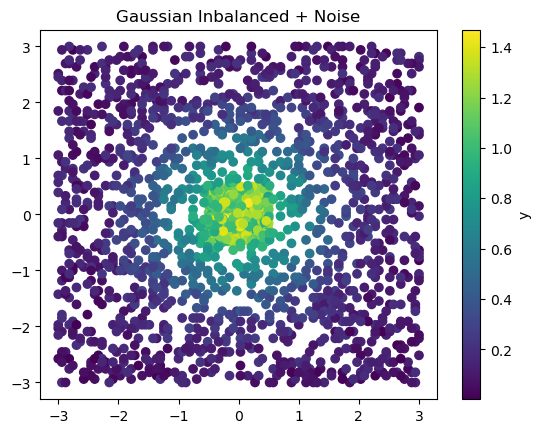

In [7]:
# Al_df = np_data[np_data['type'].isin(name1[0:150])]
# Al_dfx = Al_df[featureNames]
# Al_dfy = Al_df[targetNames]


# Rd_df = np_data[np_data['type'].isin(name2[0:150])]
# Rd_dfx = Rd_df[featureNames]
# Rd_dfy = Rd_df[targetNames]
# Rd_pca = pca.fit_transform(Rd_df)

plt.figure()
#plt.scatter(Al_dfx,Al_dfy)
#plt.scatter(Rd_dfx,Rd_dfy)
#plt.scatter(Al_dfx['x1'],Al_dfx['x2'],c=Al_dfy['y'])
#plt.scatter(Rd_dfx['x1'],Rd_dfx['x2'],c=Rd_dfy['y'])
plt.scatter(np_data['x1'],np_data['x2'],c=np_data['y'])
plt.colorbar(label = 'y')
plt.title("Gaussian Inbalanced + Noise")
plt.show()


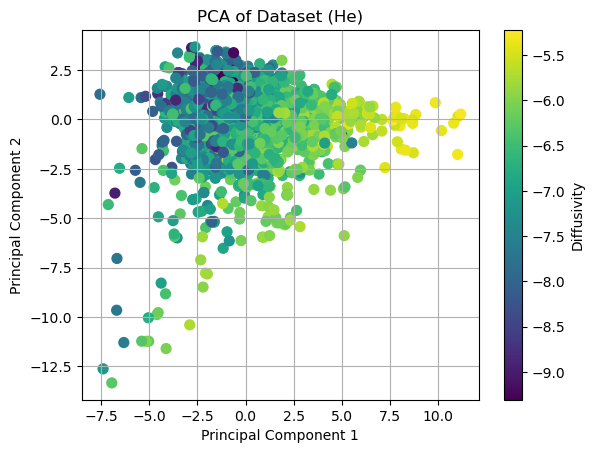

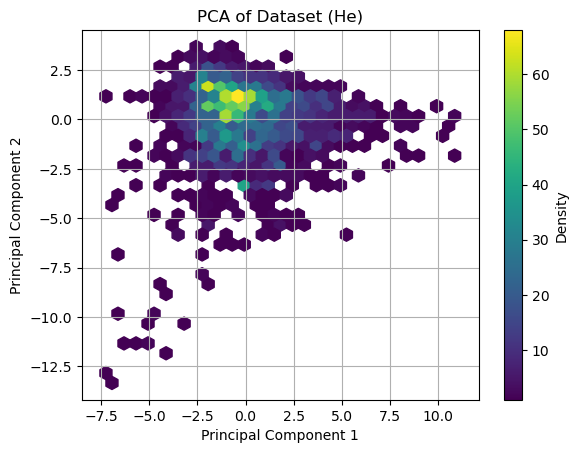

In [34]:

x = np_data[featureNames].to_numpy()
y = np_data[targetNames].to_numpy()

scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(x_normalized)

fig = plt.figure()
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', s=50)
plt.colorbar(scatter, label='Diffusivity')
plt.title('PCA of Dataset (He)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
#plt.colorbar(scatter, label='Class Label')  # Add a color bar for class labels if available
plt.grid(True)
plt.show()


fig = plt.figure()
plt.hexbin(X_pca[:, 0], X_pca[:, 1], gridsize=30, cmap='viridis', mincnt=1)
plt.colorbar(label='Density')
plt.title('PCA of Dataset (He)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
#plt.colorbar(scatter, label='Class Label')  # Add a color bar for class labels if available
plt.grid(True)
plt.show()

In [29]:
def create_results(res_path):
    
    df = pd.read_csv(res_path + '_0.csv')
    df = df[['averageError']]
    res = df
    for i in range(1,10):
        df = pd.read_csv(res_path + f'_{i}.csv')
        df = df[['averageError']]
        res += df

    return res / 10    


def stat_test(df1,df2):
    
    arr1 = df1.to_numpy()
    arr2 = df2.to_numpy()

    t_stat, p_value = stats.ttest_rel(arr1, arr2)
    return t_stat,p_value

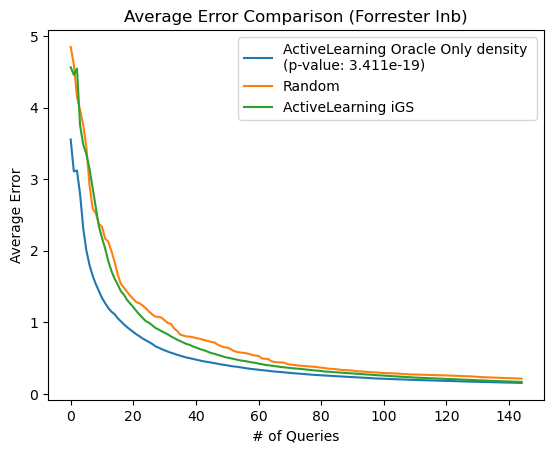

In [36]:
# df1 = pd.read_csv('./ALresults/Real/CH4/AL_ch4_150_oracle_only_density_0.csv')
# df2 = pd.read_csv('./ALresults/Real/CH4/Rd_ch4_150_full_0.csv')
# df3 = pd.read_csv('./ALresults/Real/He/AL_he_150_oracle_only_iGS.csv')
# df4 = pd.read_csv('./ALresults/Real/He/AL_he_150_oracle_only_density_active.csv')


# df1 = df1[['averageError']]
# df2 = df2[['averageError']]
# df3 = df3[['averageError']]
# df4 = df4[['averageError']]

df1 = create_results('./ALresults/Synthetic/Forrester/Forrester_inb/Al_forrester_150_oracle_only_density')
df2 = create_results('./ALresults/Synthetic/Forrester/Forrester_inb/Rd_forrester_150_full')
df3 = create_results('./ALresults/Synthetic/Forrester/Forrester_inb/Al_forrester_150_oracle_only_iGS')
# df4 = create_results('./ALresults/Real/N2/AL_n2_150_oracle_only_density_active')

t_v, p_v = stat_test(df1,df2)
p_v = p_v.item()

plt.figure()
plt.plot(df1, label='ActiveLearning Oracle Only density')
plt.plot(df2, label='Random')
plt.plot(df3, label='ActiveLearning iGS')
# plt.plot(df4, label='ActiveLearning density with random')
#plt.plot(df4, label='ActiveLearning with mae estimation')
#plt.axhline(y=8.13, color='red', linestyle='--', label='min Rand')
plt.xlabel('# of Queries')
plt.ylabel('Average Error')
plt.title('Average Error Comparison (Forrester Inb)')

handles, labels = plt.gca().get_legend_handles_labels()

#labels.append(f'p-value: {p_v:.3e}')
labels[0] += f' \n(p-value: {p_v:.3e})'
#plt.xlim(100,150)
#plt.legend()
plt.legend(handles, labels)
plt.show()

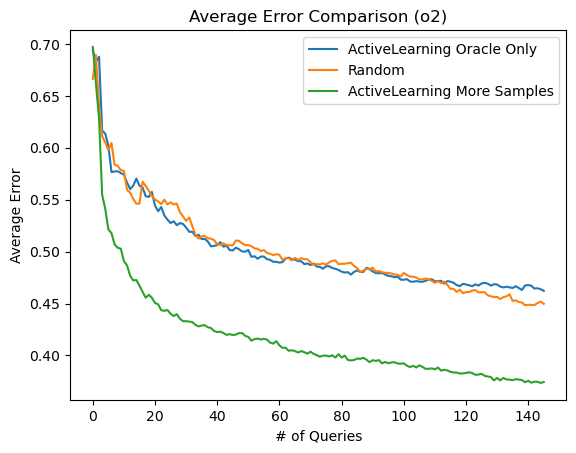

In [72]:
# Oxygen Only
df1 = pd.read_csv('./ALresults/AL_o2n2_150_oracle_only_cat.csv')
df2 = pd.read_csv('./ALresults/Rd_o2n2_150_full.csv')
df3 = pd.read_csv('./ALresults/AL_o2n2_150_more_samples.csv')

df1 = df1[['averageError']]
df2 = df2[['averageError']]
df3 = df3[['averageError']]
plt.figure()
plt.plot(df1, label='ActiveLearning Oracle Only ')
plt.plot(df2, label='Random')
plt.plot(df3, label='ActiveLearning More Samples')
#plt.plot(df4, label='ActiveLearning with mae estimation')
#plt.axhline(y=8.13, color='red', linestyle='--', label='min Rand')
plt.xlabel('# of Queries')
plt.ylabel('Average Error')
plt.title('Average Error Comparison (o2)')
#plt.ylim(5,20)
#plt.xlim(0,150)
plt.legend()
plt.show()

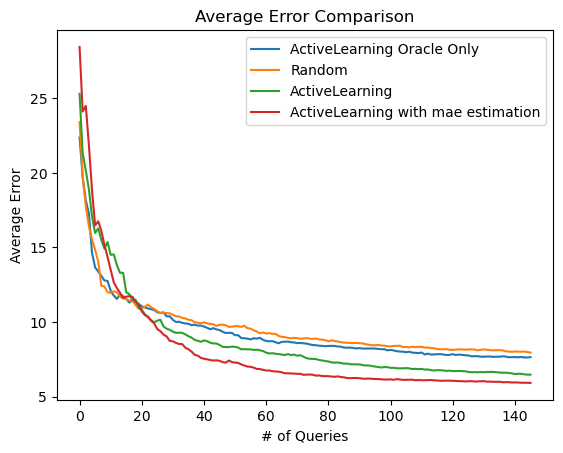

In [105]:
df1 = pd.read_csv('./ALresults/AL_meth_150_oracle_only.csv')
df2 = pd.read_csv('./ALresults/Rd_meth_100_full.csv')
df3 = pd.read_csv('./ALresults/AL_meth_150_more_samples.csv')
df4 = pd.read_csv('./ALresults/AL_meth_150_more_samples_mae_est.csv')



df1 = df1[['averageError']]
df2 = df2[['averageError']]
df3 = df3[['averageError']]
df4 = df4[['averageError']]


plt.figure()
plt.plot(df1, label='ActiveLearning Oracle Only ')
plt.plot(df2, label='Random')
plt.plot(df3, label='ActiveLearning')
plt.plot(df4, label='ActiveLearning with mae estimation')
#plt.axhline(y=8.13, color='red', linestyle='--', label='min Rand')
plt.xlabel('# of Queries')
plt.ylabel('Average Error')
plt.title('Average Error Comparison')
#plt.ylim(5,20)
#plt.xlim(0,150)
plt.legend()
plt.show()

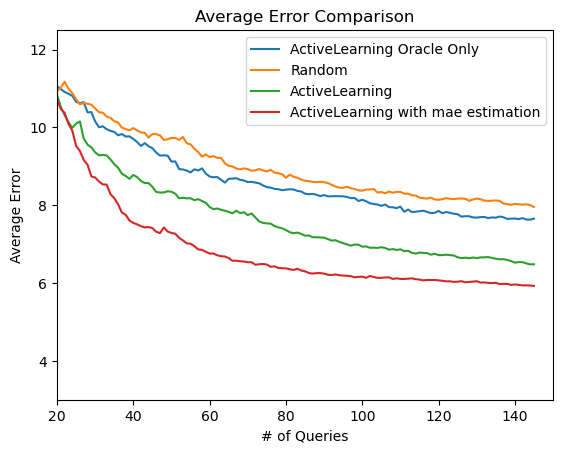

In [106]:
df1 = pd.read_csv('./ALresults/AL_meth_150_oracle_only.csv')
df2 = pd.read_csv('./ALresults/Rd_meth_100_full.csv')
df3 = pd.read_csv('./ALresults/AL_meth_150_more_samples.csv')
df4 = pd.read_csv('./ALresults/AL_meth_150_more_samples_mae_est.csv')


df1 = df1[['averageError']]
df2 = df2[['averageError']]
df3 = df3[['averageError']]
df4 = df4[['averageError']]

plt.figure()
plt.plot(df1, label='ActiveLearning Oracle Only ')
plt.plot(df2, label='Random')
plt.plot(df3, label='ActiveLearning')
plt.plot(df4, label='ActiveLearning with mae estimation')
plt.xlabel('# of Queries')
plt.ylabel('Average Error')
plt.title('Average Error Comparison')
plt.ylim(3,12.5)
plt.xlim(20,150)
plt.legend()
plt.show()

   sizeOfTrainingSet  averageError  stdErrorOfMeanError  \
0                  5      3.736963             0.437900   
1                  6      3.553431             0.400896   
2                  7      3.583923             0.556732   
3                  8      3.450646             0.482377   
4                  9      3.387176             0.438661   

   stdDeviationOfMeanError  
0                 0.979173  
1                 0.981989  
2                 1.472973  
3                 1.364368  
4                 1.315983  


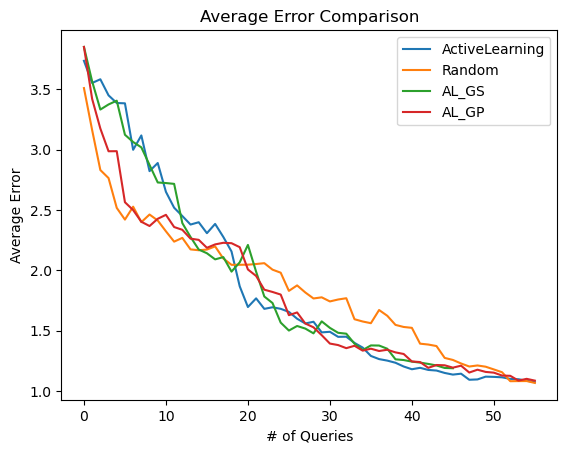

In [79]:
df1 = pd.read_csv('./ALresults/All_zifs/AL_500.csv')
df2 = pd.read_csv('./ALresults/All_zifs/Rd_500.csv')
df3 = pd.read_csv('./ALresults/AL_meth_100_bs.csv')
df4 = pd.read_csv('./ALresults/All_zifs/AL_500_gp.csv')


print(df1.head())
df1 = df1[['averageError']]
df2 = df2[['averageError']]
df3 = df3[['averageError']]
df4 = df4[['averageError']]

plt.figure()
plt.plot(df1, label='ActiveLearning')
plt.plot(df2, label='Random')
plt.plot(df3, label='AL_GS')
plt.plot(df4, label='AL_GP')
plt.xlabel('# of Queries')
plt.ylabel('Average Error')
plt.title('Average Error Comparison')
#plt.ylim(0,9)
#plt.xlim(0,100)
plt.legend()
plt.show()